In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


- pandas: Handles time-series data.

- numpy: Performs numerical operations.

- matplotlib & seaborn: Visualizes the data.

- statsmodels.tsa: Helps with time-series analysis (ADF test, ARIMA model, ACF/PACF plots).

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


### Load the Dataset

For this example, we will use the Air Passenger dataset, which contains the number of monthly airline passengers from 1949 to 1960.

            Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121


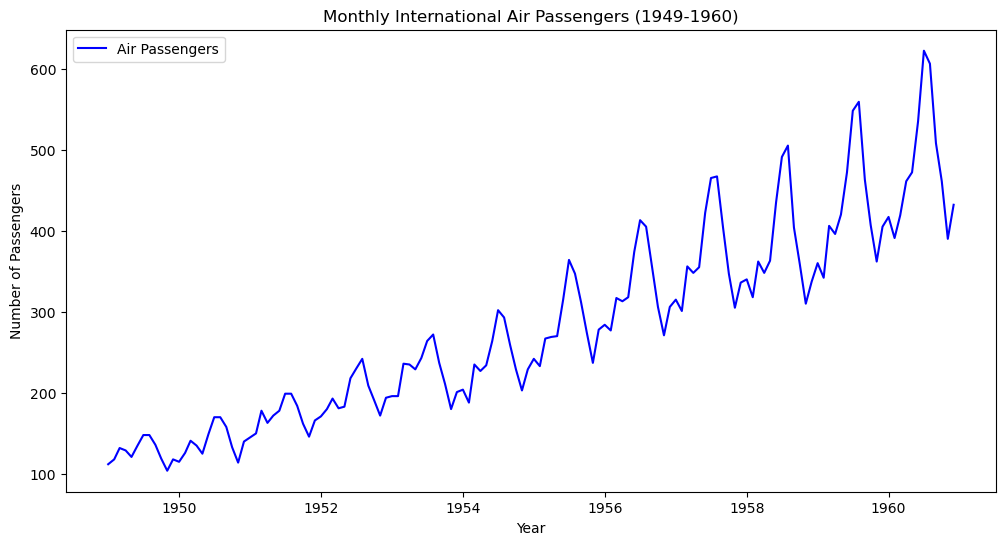

In [16]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# Display first few rows
print(df.head())

# Plot the time-series data
plt.figure(figsize=(12, 6))
plt.plot(df, label='Air Passengers', color='blue')
plt.title("Monthly International Air Passengers (1949-1960)")
plt.xlabel("Year")
plt.ylabel("Number of Passengers")
plt.legend()
plt.show()

**What We Observe?**

- There is a clear increasing trend (number of passengers rising over time).

- Seasonality is present (peaks and dips occur at regular intervals).



### Check for Stationarity

A time series must be stationary for ARIMA to work effectively. We use the Augmented Dickey-Fuller (ADF) test to check this.

In [82]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] > 0.05:
        print("The data is Non-Stationary")
    else:
        print("The data is Stationary")

# Check stationarity of the original data
check_stationarity(df['Passengers'])

ADF Statistic: 0.7447451908537114
p-value: 0.9906898135467845
The data is Non-Stationary


**What Does This Mean?**

- If p-value > 0.05, the data is non-stationary, meaning we must transform it.

- If p-value < 0.05, the data is already stationary, and we can proceed.

### Make Data Stationary (Differencing)

If the data is non-stationary, we apply differencing (subtracting previous values).

ADF Statistic: -2.9806314665113973
p-value: 0.03674319543666231
The data is Stationary


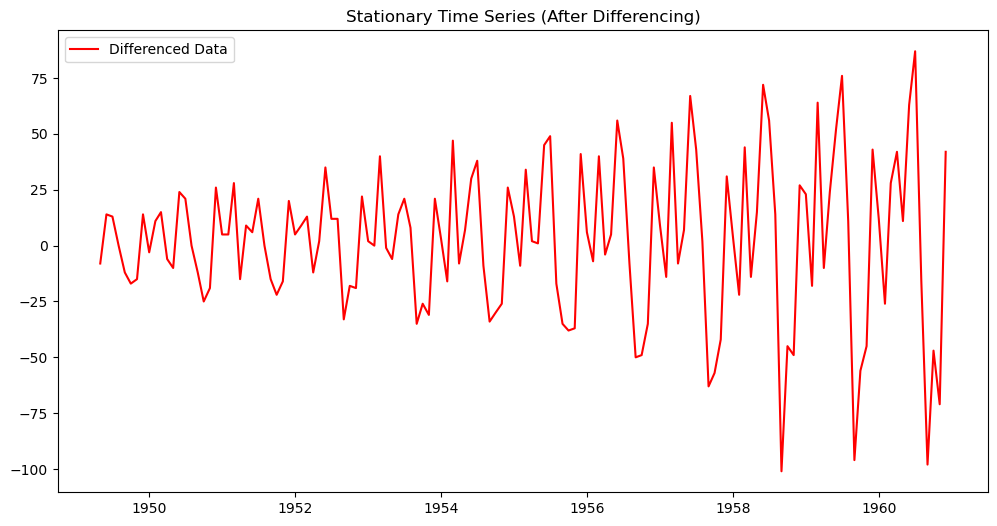

In [91]:
# Apply first-order differencing
df['Passengers_diff'] = df['Passengers'].diff()

# Drop NA values
df.dropna(inplace=True)

# Check stationarity again
check_stationarity(df['Passengers_diff'])

# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers_diff'], label='Differenced Data', color='red')
plt.title("Stationary Time Series (After Differencing)")
plt.legend()
plt.show()

### Apply Second-Order Differencing

ADF Statistic: -16.201761402004063
p-value: 4.0704360706069305e-29
The data is Stationary


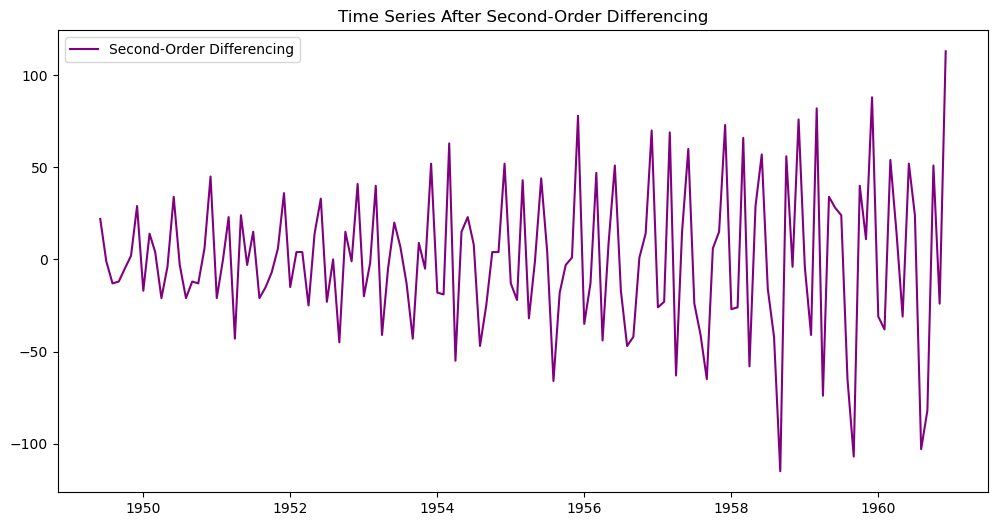

In [94]:
df['Passengers_diff2'] = df['Passengers_diff'].diff()
df.dropna(inplace=True)

# Check stationarity again
check_stationarity(df['Passengers_diff2'])

# Plot the second-order differenced data
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers_diff2'], label='Second-Order Differencing', color='purple')
plt.title("Time Series After Second-Order Differencing")
plt.legend()
plt.show()


### Identify ARIMA Parameters (p, d, q)

To choose the best p, d, q values, we plot ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function).

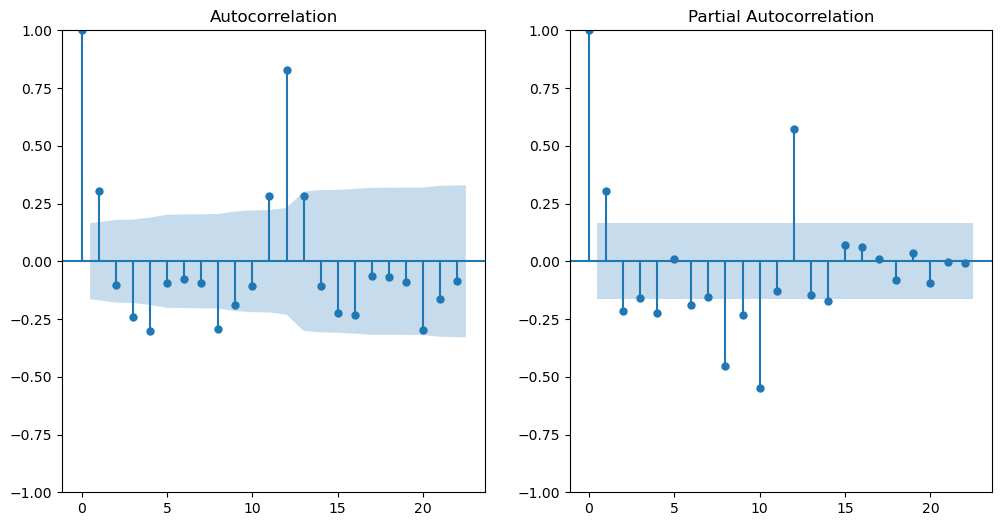

In [60]:
# Plot ACF & PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_acf(df['Passengers_diff'], ax=ax[0])   # Determines 'q' (MA order)
plot_pacf(df['Passengers_diff'], ax=ax[1])  # Determines 'p' (AR order)
plt.show()

**How to Choose ARIMA Parameters?**
- p (AR order) → Look at PACF, check where it cuts off (e.g., p = 2).

- q (MA order) → Look at ACF, check where it cuts off (e.g., q = 1).

- d (Differencing order) → Since we took 1st difference, d = 1.

Thus, we use ARIMA(2,1,1).

### Train the ARIMA Model

Now, we fit an ARIMA(2,1,1) model.

In [70]:
# Fit the ARIMA model
model = ARIMA(df['Passengers'], order=(2, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

C:\Users\DELL 4\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL 4\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL 4\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  142
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -676.433
Date:                Tue, 25 Mar 2025   AIC                           1360.865
Time:                        12:58:07   BIC                           1372.660
Sample:                    03-01-1949   HQIC                          1365.658
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0909      0.084     13.043      0.000       0.927       1.255
ar.L2         -0.4890      0.098     -4.984      0.000      -0.681      -0.297
ma.L1         -0.8443      0.074    -11.376      0.0

**What Happens Here?**

- The ARIMA model learns patterns from past data.

- The summary provides information on model coefficients and performance.

### Forecast Future Values

Let's predict the next 12 months (1 year) of airline passengers.

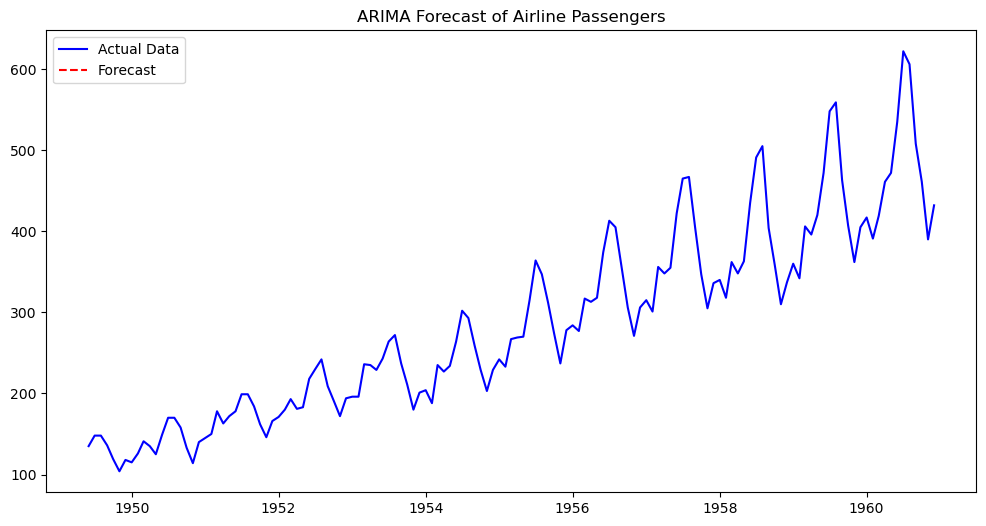

In [96]:
# Forecast for the next 12 months
forecast = model_fit.forecast(steps=12)

# Create future dates
future_dates = pd.date_range(start='1961-01-01', periods=12, freq='MS')

# Convert forecast to DataFrame
forecast_df = pd.DataFrame(forecast, index=future_dates, columns=['Forecast'])

# Plot actual vs forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], label='Actual Data', color='blue')
plt.plot(forecast_df, label='Forecast', linestyle='dashed', color='red')
plt.title("ARIMA Forecast of Airline Passengers")
plt.legend()
plt.show()


In [98]:
forecast_series = pd.Series(forecast, index=future_dates)
forecast_df = pd.DataFrame({'Forecast': forecast_series})
print(df.index[-5:])   # Check last 5 index values of actual data
print(forecast_df.index)  # Check forecast index
df.index = pd.to_datetime(df.index)


DatetimeIndex(['1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01',
               '1960-12-01'],
              dtype='datetime64[ns]', name='Month', freq=None)
DatetimeIndex(['1961-01-01', '1961-02-01', '1961-03-01', '1961-04-01',
               '1961-05-01', '1961-06-01', '1961-07-01', '1961-08-01',
               '1961-09-01', '1961-10-01', '1961-11-01', '1961-12-01'],
              dtype='datetime64[ns]', freq='MS')


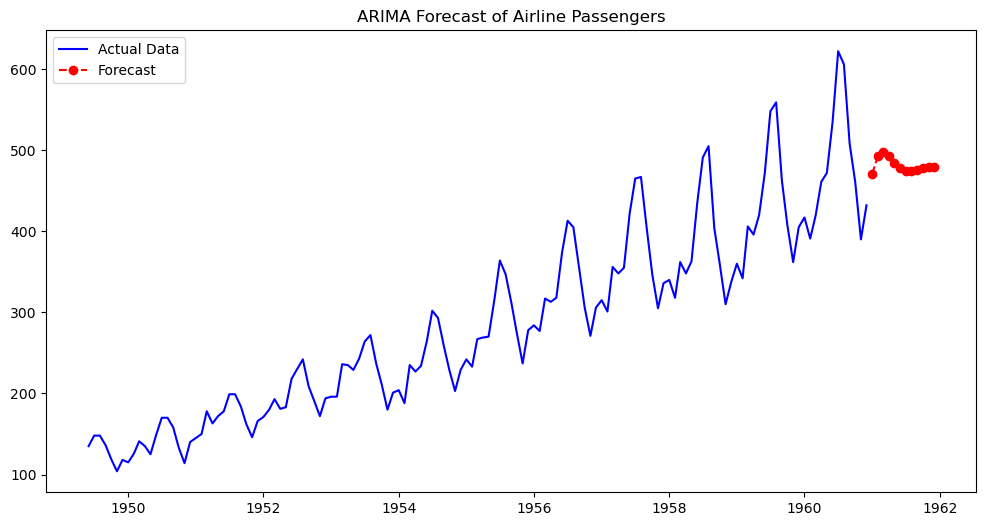

In [100]:
plt.figure(figsize=(12, 6))
plt.plot(df['Passengers'], label='Actual Data', color='blue')

# Explicitly set linestyle and marker to make the forecast more visible
plt.plot(forecast_df.index, forecast_df['Forecast'], linestyle='dashed', marker='o', color='red', label='Forecast')

plt.title("ARIMA Forecast of Airline Passengers")
plt.legend()
plt.show()


### Evaluate Model Performance

To measure how well our model performs, we compute Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE).

In [106]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Get predictions for existing data
train_size = int(len(df) * 0.8)
train, test = df['Passengers'][:train_size], df['Passengers'][train_size:]

# Fit ARIMA on train data
model_train = ARIMA(train, order=(2, 1, 1))
model_train_fit = model_train.fit()

# Predict on test data
test_pred = model_train_fit.forecast(steps=len(test))

# Calculate errors
mae = mean_absolute_error(test, test_pred)
rmse = np.sqrt(mean_squared_error(test, test_pred))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")


Mean Absolute Error (MAE): 62.57443939411796
Root Mean Squared Error (RMSE): 82.45900952297315


C:\Users\DELL 4\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL 4\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\DELL 4\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Lower MAE and RMSE values mean better accuracy.

In [111]:
print("Min value:", df['Passengers'].min())
print("Max value:", df['Passengers'].max())
print("Mean value:", df['Passengers'].mean())

Min value: 104
Max value: 622
Mean value: 285.978417266187


 Benchmark Against a Simple Model
A good way to check if your ARIMA model is working is to compare it against a naïve model (a simple forecast like using the previous month's value).

In [118]:
df['naive_forecast'] = df['Passengers'].shift(1)  # Use previous month’s value as forecast

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_naive = mean_absolute_error(df['Passengers'][1:], df['naive_forecast'][1:])
rmse_naive = np.sqrt(mean_squared_error(df['Passengers'][1:], df['naive_forecast'][1:]))

print("Naive Model MAE:", mae_naive)
print("Naive Model RMSE:", rmse_naive)

Naive Model MAE: 26.471014492753625
Naive Model RMSE: 34.262731686319114


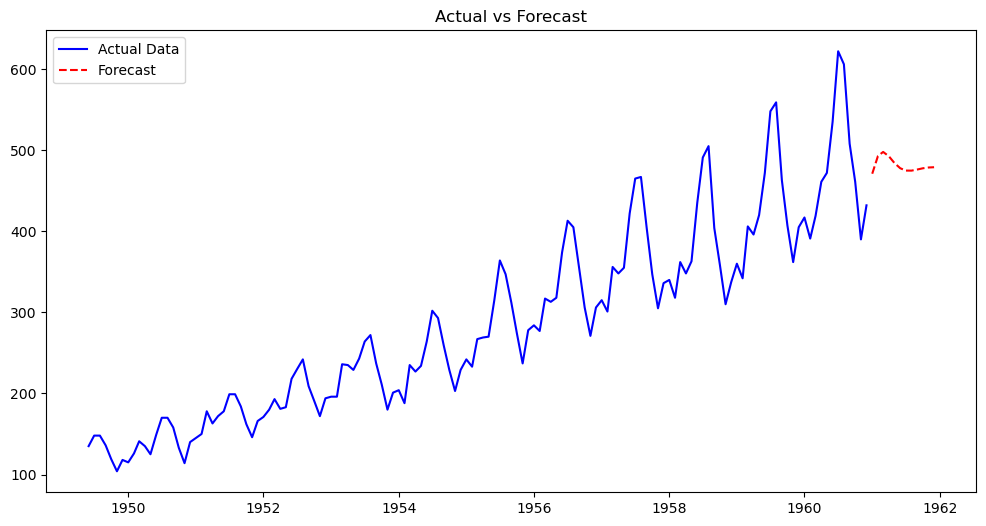

In [120]:
plt.figure(figsize=(12,6))
plt.plot(df['Passengers'], label='Actual Data', color='blue')
plt.plot(forecast_df, label='Forecast', linestyle='dashed', color='red')
plt.legend()
plt.title("Actual vs Forecast")
plt.show()